In [6]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Masking
import keras_tuner as kt
from pathlib import Path
import joblib # for saving and loading variables
import io
import contextlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score

In [2]:
base_folder = Path('C:/Users/ilkele4s/')

main_results_folder = 'ML_Results'
new_results_folder = 'LSTM_noFunction_allElectrodes_results'

data_folder = 'Data'
data_file = 'All_Electrodes_data.csv'

tune_folder = 'Tune'
project_name = 'Random_30'

In [3]:
results_dir = os.path.join(base_folder,main_results_folder)

new_results_dir = os.path.join(results_dir,new_results_folder)

In [4]:
os.mkdir(new_results_dir)

print(new_results_dir)

C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results


In [5]:
tune_dir = os.path.join(new_results_dir,tune_folder)

In [7]:
# load the data 
data_dir = os.path.join(base_folder,data_folder)

data_file_path = os.path.join(data_dir,data_file)

print(data_file_path)

Data = pd.read_csv(data_file_path, header = None)

C:\Users\ilkele4s\Data\All_Electrodes_data.csv


In [8]:
# structure samples for LSTM

data_array = np.array(Data)

n_samples = data_array.shape[0]
n_features = data_array.shape[1]

bin_cur = 1
bin_past = 3

bins_predict = bin_cur + bin_past # 3 previous + 1 current

formatted_data = np.zeros([n_samples,bins_predict,n_features])

start_idx=0
for i in range(n_samples-bin_past):
    end_idx=start_idx+bins_predict
    formatted_data[i+bin_past,:,:]=data_array[start_idx:end_idx,:]
    start_idx=start_idx+1

In [9]:
# create a label set

n_zones = 45
n_trials = 32

cat_zones = keras.utils.to_categorical(np.r_[1:n_zones+1] ,num_classes=46)
cat_zones = np.delete(cat_zones,0,1)
labels_all_trials = np.tile(cat_zones, 32)

reshaped_labels_all_trials = np.reshape(labels_all_trials, [n_samples,45])



In [10]:
# test - validation - train split (20/20/60)

all_ind = np.random.choice(np.arange(0, n_samples, 1), n_samples, replace=False) 
test_ind = all_ind[:int(n_samples/5)] # 20

validation_ind = all_ind[int(n_samples/5):int(n_samples/5+n_samples/5)] # 20 

train_ind = all_ind[int(n_samples/5+n_samples/5):] # 60


In [11]:
# comparing the elements of test - validation - train split 

comparison_matrix = train_ind[:, np.newaxis] == test_ind
true_ind = np.where(comparison_matrix == True)
repeat = np.shape(true_ind)

if not repeat[1] == 0 :
    print('Repeated elements!')
    raise SystemExit("Repeated elements in TrainTest!")
    
else :
     print('No repeated elements in TrainTest!')
    

comparison_matrix2 = train_ind[:, np.newaxis] == validation_ind
true_ind = np.where(comparison_matrix2 == True)
repeat = np.shape(true_ind)

if not repeat[1] == 0 :
    #print('Repeated elements!')
    raise SystemExit("Repeated elements in TrainValidation!")
else :
    print('No repeated elements in TrainValidation!')
    
    
comparison_matrix3 = test_ind[:, np.newaxis] == validation_ind
true_ind = np.where(comparison_matrix3 == True)
repeat = np.shape(true_ind)

if not repeat[1] == 0 :
    #print('Repeated elements!')
    raise SystemExit("Repeated elements in TestValidation!")
else :
     print('No repeated elements in TestValidation!')
          

No repeated elements in TrainTest!
No repeated elements in TrainValidation!
No repeated elements in TestValidation!


In [12]:
print(np.shape(test_ind))
print(np.shape(validation_ind))
print(np.shape(train_ind))

(288,)
(288,)
(864,)


In [13]:
test_samples = formatted_data[test_ind,:,:]
test_labels = reshaped_labels_all_trials[test_ind,:]

train_samples = formatted_data[train_ind,:,:]
train_labels = reshaped_labels_all_trials[train_ind,:]

validation_samples = formatted_data[validation_ind,:,:]
validation_labels = reshaped_labels_all_trials[validation_ind,:]

In [14]:
train_samples[np.isnan(train_samples)] = 0
test_samples[np.isnan(test_samples)] = 0
validation_samples[np.isnan(validation_samples)] = 0

In [15]:
print(np.shape(test_samples))
print(np.shape(train_samples))
print(np.shape(validation_samples))

print(np.shape(test_labels))
print(np.shape(train_labels))
print(np.shape(validation_labels))

(288, 4, 17400)
(864, 4, 17400)
(288, 4, 17400)
(288, 45)
(864, 45)
(288, 45)


In [16]:
joblib.dump(train_samples, os.path.join(new_results_dir,'train_samples.sav'))
joblib.dump(train_labels, os.path.join(new_results_dir,'train_labels.sav'))

joblib.dump(test_samples, os.path.join(new_results_dir,'test_samples.sav'))
joblib.dump(test_labels, os.path.join(new_results_dir,'test_labels.sav'))

joblib.dump(validation_samples, os.path.join(new_results_dir,'validation_samples.sav'))
joblib.dump(validation_labels, os.path.join(new_results_dir,'validation_labels.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_noFunction_allElectrodes_results\\validation_labels.sav']

In [17]:
class MyHyperModel(kt.HyperModel):

    def build(self,hp):
        
            LSTM_units = [30, 40, 50]
            Drop_rate = [.20, .30, .40]
            RecDrop_rate = [.20, .30, .40]
            learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

            model=Sequential()
            model.add(Masking(mask_value=0, input_shape=(4, n_features))), # n_features = 17400
            model.add(LSTM(hp.Choice('LSTM_units',LSTM_units),                
                           input_shape=(4, n_features), 
                           dropout=hp.Choice('Drop_rate',Drop_rate),
                           recurrent_dropout=hp.Choice('RecDrop_rate', RecDrop_rate)))

            model.add(Dense(45, activation='softmax'))
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])

            return model 
        
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )




In [18]:
#tuner = kt.GridSearch(
#    MyHyperModel(),
#    objective =kt.Objective("val_loss", direction="min"),
#    overwrite=True,
#    directory=NewDirectory ,
#    project_name="tune_hypermodel",
#)



In [18]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective =kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_trials=30,
    directory= tune_dir ,
   project_name = project_name
)


In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
LSTM_units (Choice)
{'default': 30, 'conditions': [], 'values': [30, 40, 50], 'ordered': True}
Drop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
RecDrop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}


In [20]:
tuner.search(train_samples, train_labels, epochs=20, validation_data=(validation_samples, validation_labels))

Trial 30 Complete [00h 02m 05s]
val_loss: 2.8666906356811523

Best val_loss So Far: 0.7922447919845581
Total elapsed time: 01h 22m 55s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary(num_trials=3)


Results summary
Results in C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 24 summary
Hyperparameters:
lr: 0.0007510387022999018
LSTM_units: 50
Drop_rate: 0.4
RecDrop_rate: 0.4
shuffle: False
Score: 0.7922447919845581

Trial 26 summary
Hyperparameters:
lr: 0.00047579851456477045
LSTM_units: 50
Drop_rate: 0.3
RecDrop_rate: 0.2
shuffle: True
Score: 0.809842050075531

Trial 05 summary
Hyperparameters:
lr: 0.0006773981501812385
LSTM_units: 40
Drop_rate: 0.4
RecDrop_rate: 0.2
shuffle: False
Score: 0.8708521723747253


In [22]:
# Capture the printed output using io.StringIO
summary_output = io.StringIO()

# Use contextlib.redirect_stdout to redirect the print output to the StringIO object
with contextlib.redirect_stdout(summary_output):
    tuner.results_summary(num_trials=3)

# Get the captured output
summary_text = summary_output.getvalue()


In [23]:
file = open(os.path.join(new_results_dir,'best_3params.txt'), 'w')
# Write content to the file
file.write(summary_text)

624

In [24]:

# Define a pattern to match files with names like "trial1", "trial2", etc.

to_remove = os.path.join(tune_dir, project_name)
pattern = "trial*"

# Use glob to find matching files
matching_files = glob.glob(os.path.join(to_remove, pattern))

# Iterate over matching files and delete them
for file_path in matching_files:
    try:
        shutil.rmtree(file_path)
        print(f"File '{file_path}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting '{file_path}': {e}")

File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_00' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_01' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_02' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_03' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_04' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_05' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_06' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_noFunction_allElectrodes_results\Tune\Random_30\trial_07' deleted successfully.
File 'C:\Users\ilkele4s\ML_Results\LSTM_

In [25]:
best_hp = tuner.get_best_hyperparameters()[0]

In [26]:
joblib.dump(best_hp, os.path.join(new_results_dir,'best_hyperparameters.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_noFunction_allElectrodes_results\\best_hyperparameters.sav']

In [27]:
model = MyHyperModel()

# building the model
best_model = model.build(best_hp)

# training the model
best_model_trained = model.fit(best_hp, best_model, train_samples, 
                               train_labels,validation_data=(validation_samples, validation_labels), epochs=30)

Epoch 1/30
27/27 [==============================] - 10s 272ms/step - loss: 3.5901 - accuracy: 0.1875 - val_loss: 3.3602 - val_accuracy: 0.2604
Epoch 2/30
27/27 [==============================] - 7s 244ms/step - loss: 2.6444 - accuracy: 0.6539 - val_loss: 2.7759 - val_accuracy: 0.5312
Epoch 3/30
27/27 [==============================] - 7s 265ms/step - loss: 1.9666 - accuracy: 0.8414 - val_loss: 2.4045 - val_accuracy: 0.6215
Epoch 4/30
27/27 [==============================] - 7s 272ms/step - loss: 1.5432 - accuracy: 0.9074 - val_loss: 2.1089 - val_accuracy: 0.7222
Epoch 5/30
27/27 [==============================] - 7s 247ms/step - loss: 1.2497 - accuracy: 0.9352 - val_loss: 1.8776 - val_accuracy: 0.7535
Epoch 6/30
27/27 [==============================] - 7s 247ms/step - loss: 1.0276 - accuracy: 0.9514 - val_loss: 1.6610 - val_accuracy: 0.8333
Epoch 7/30
27/27 [==============================] - 7s 256ms/step - loss: 0.8631 - accuracy: 0.9595 - val_loss: 1.5486 - val_accuracy: 0.8194
Epoch

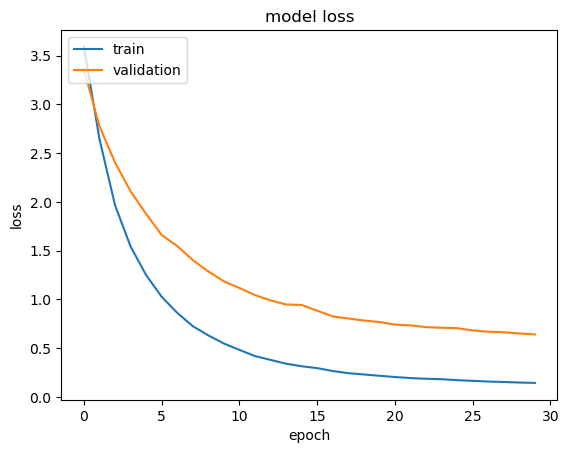

In [28]:
plt.plot(best_model_trained.history['loss'])
plt.plot(best_model_trained.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')

ay = plt.gca()

ay.yaxis.set_major_locator(MultipleLocator(base=0.50)) 


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(new_results_dir,'Model_loss.png'))
plt.show()

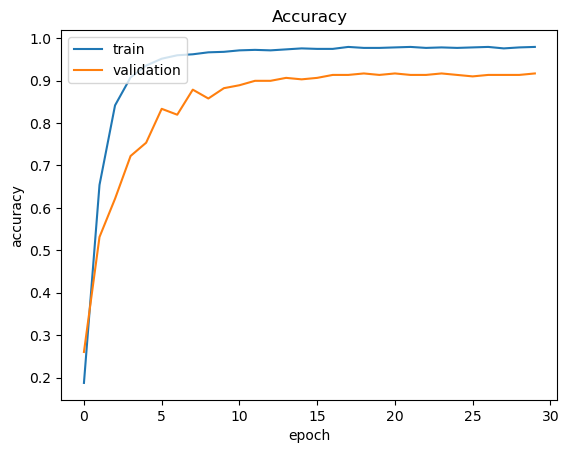

In [29]:
plt.plot(best_model_trained.history['accuracy'])
plt.plot(best_model_trained.history['val_accuracy'])


ay = plt.gca()
ay.yaxis.set_major_locator(MultipleLocator(base=0.10)) 

plt.legend(['train', 'validation'], loc='upper left')

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.savefig(os.path.join(new_results_dir,'Model_accuracy.png'))
plt.show()

In [30]:
predictions = best_model.predict(test_samples)

predicted_labels = np.argmax(predictions, axis=1) + 1

true_label = np.argmax(test_labels, axis=1) + 1

9/9 [==============================] - 1s 57ms/step


In [31]:
joblib.dump(predictions, os.path.join(new_results_dir,'predictions.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_noFunction_allElectrodes_results\\predictions.sav']

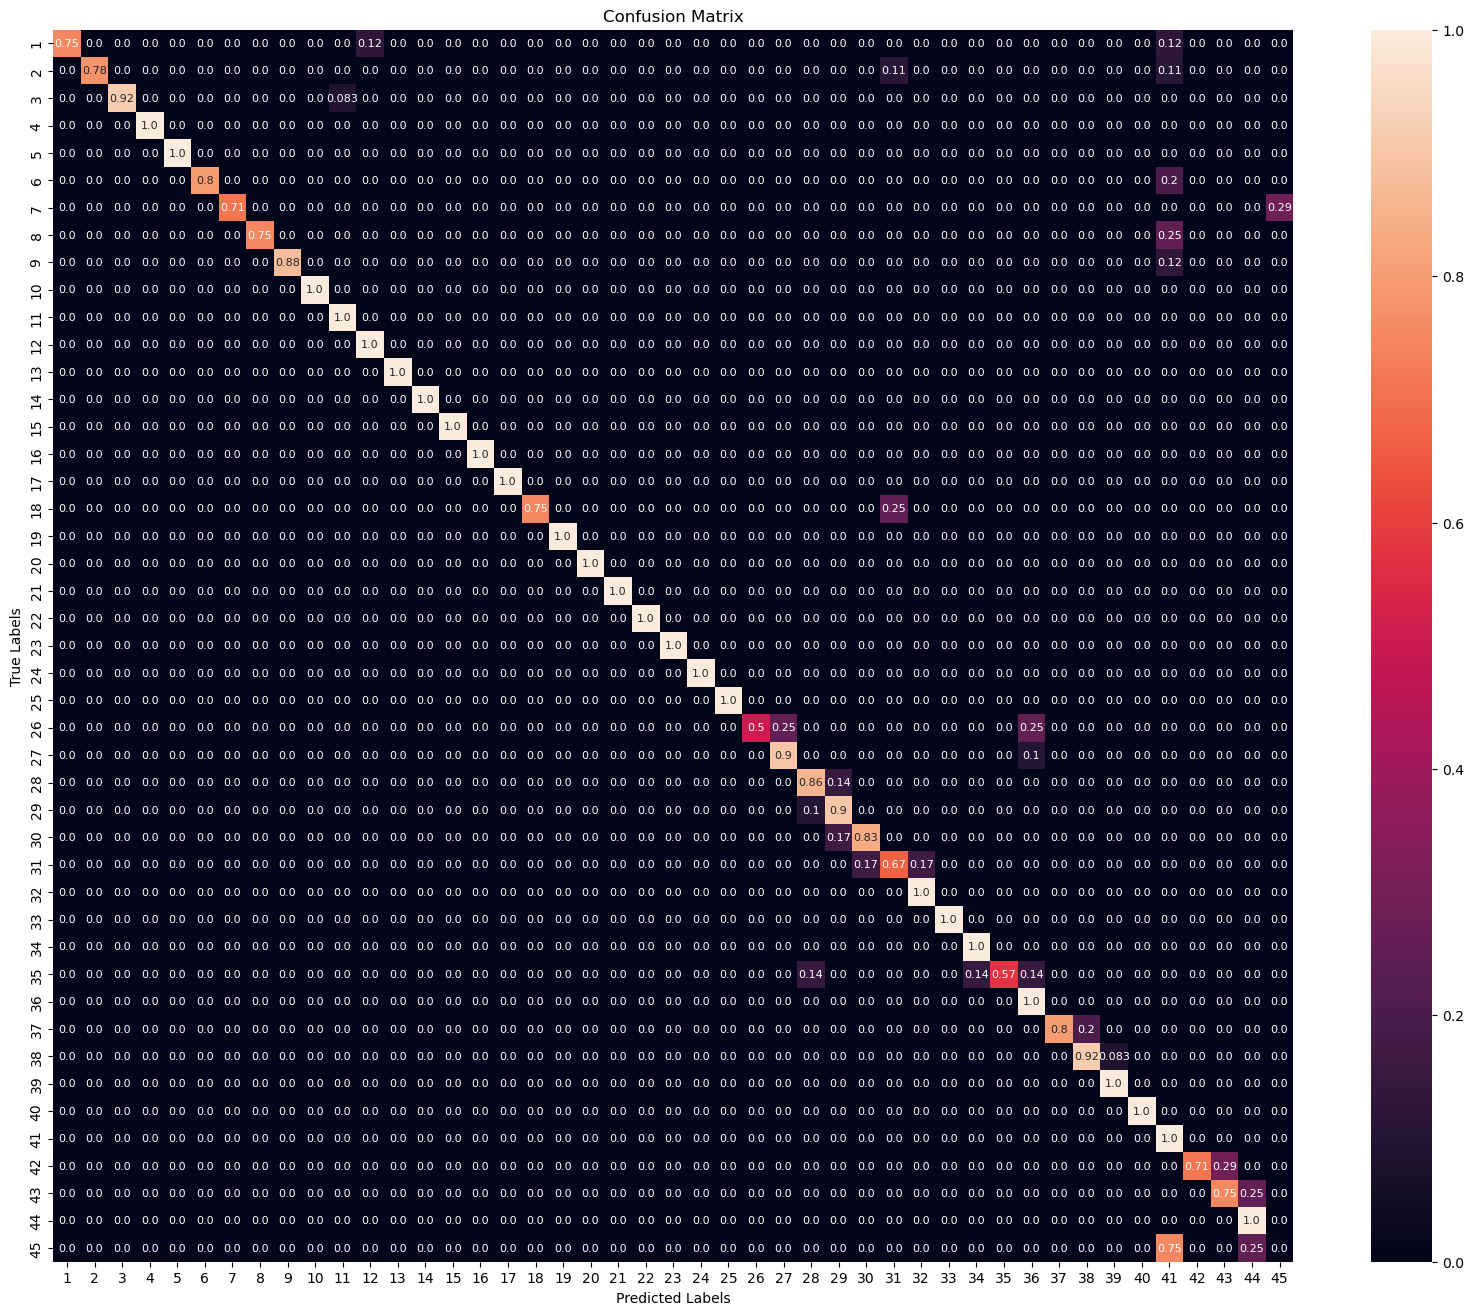

In [32]:
#%%
cm = confusion_matrix(true_label, predicted_labels, normalize='true')
#%%
class_labels = [str(i) for i in range(1, 46)]
#%%
plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='.2',annot=True, annot_kws={"size": 8}, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig(os.path.join(new_results_dir,'Cm_optim.png'))
plt.show()

In [33]:
report = classification_report(true_label, predicted_labels, output_dict=True)

In [34]:
f1 = report['weighted avg']

In [35]:
file = open(os.path.join(new_results_dir,'F1.txt'), 'w')
# Write content to the file
file.write(str(f1))

111

In [40]:
Acc = balanced_accuracy_score(true_label, predicted_labels)
print(Acc)

0.8831834215167548


In [39]:
file = open(os.path.join(new_results_dir,'Acc_balanced.txt'), 'w')
# Write content to the file
file.write(str(Acc))
file.close()